This page was created from a Jupyter notebook. The original notebook can be found [here](https://github.com/klane/databall/blob/master/notebooks/feature-selection.ipynb). It investigates which attributes in the database to select for further study. First we must import the necessary installed modules.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from sklearn.preprocessing import LabelEncoder, FunctionTransformer, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
import datetime as dt
import matplotlib.dates as mdates

Next we need to import a few local modules.

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from databall.database import Database
from databall.model_selection import train_test_split
from databall.plotting import cross_val_curves, format_538
from databall.plotting import cross_val_precision_recall_curve, cross_val_roc_curve
from databall.profit import profit
from databall.simulate import simulate
from databall.util import select_columns, stat_names

As before, let's apply the FiveThirtyEight plot style.

In [3]:
plt.style.use('fivethirtyeight')

# Collect the Data

The first step is to bring in the data similar to what was done during [data exploration](data-exploration.md).

In [4]:
database = Database('../data/nba.db')

The betting stats method combines game stats with betting data. The method takes a rolling average of stats where the window size (number of games to average over) is determined by the window parameter. The beginning of the season where the rolling window is invalid is filled in with an expanding mean. I removed all seasons prior to 2006 to reduce the computational time of cross-validation and parameter tuning efforts.

In [5]:
games = database.betting_stats(window=10)
games = games[games.SEASON>=2006]

# Straight Up vs. Spread Betting

First let's look at how well we do if we simply bet on the favorite. The code below creates a pandas `DataFrame` that always predicts the favorite (indicated by a negative point spread) wins. The profit function looks at the predicted variable and calculates the profit at the end of each day of the season.

In [6]:
predictions = games.loc[games.SEASON==2016, ['SEASON', 'GAME_DATE', 'TEAM_NET_RTG', 'TEAM_NET_RTG_AWAY',
                                             'HOME_SPREAD', 'HOME_WL', 'HOME_SPREAD_WL']].dropna()
predictions['HOME_WL_PRED'] = 'W'
predictions['HOME_SPREAD_WL_PRED'] = 'W'
predictions.loc[predictions.HOME_SPREAD > 0, ['HOME_WL_PRED', 'HOME_SPREAD_WL_PRED']] = 'L'
var_predict = 'HOME_SPREAD_WL'
days, cumper, cumprofit = profit(predictions, var_predict='HOME_WL', bet_amount=100)
days_spread, cumper_spread, cumprofit_spread = profit(predictions, var_predict=var_predict, bet_amount=100)

The chart below tracks cumulative accuracy of betting on the favorite to win straight up. This uses no machine learning at all and simply says the home team wins if the home point spread is negative. This works quite well for predicting winners straight up and settles out to almost 70% accuracy.

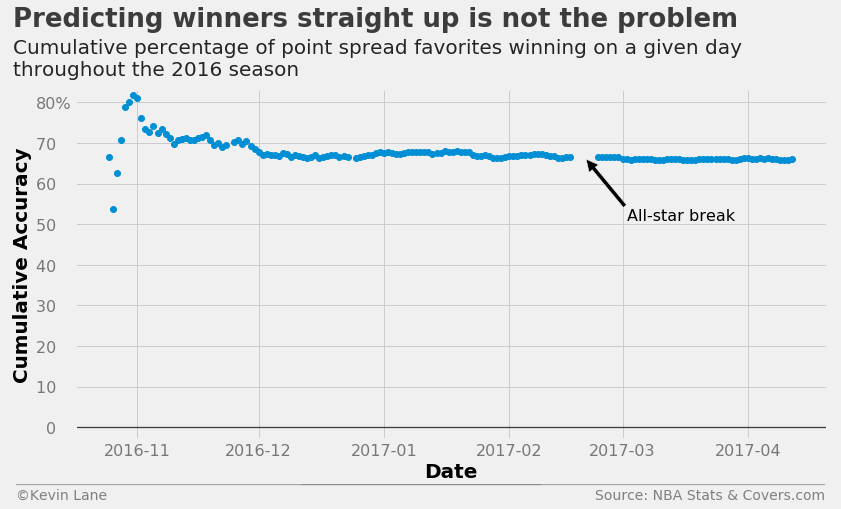

In [7]:
fig = plt.figure(figsize=(12, 6))
plt.plot_date(days, cumper*100)
plt.ylim(-3)
x = [dt.datetime(2017, 2, 20), dt.datetime(2017, 3, 2)]
plt.annotate('All-star break', xy=(mdates.date2num(x[0]),66), xytext=(mdates.date2num(x[1]),51),
             fontsize=16, arrowprops=dict(facecolor='black'))

title = 'Predicting winners straight up is not the problem'
subtitle = '''Cumulative percentage of point spread favorites winning on a given day
throughout the 2016 season'''
format_538(fig, 'NBA Stats & Covers.com', xlabel='Date', ylabel='Cumulative Accuracy', title=title,
           subtitle=subtitle, xoff=(-0.09, 1.01), yoff=(-0.12, -0.17), toff=(-0.082, 1.18),
           soff=(-0.082, 1.04), suffix='%', suffix_offset=3)
plt.show()

The chart below shows cumulative profit in a hypothetical scenario where bettors are allowed to bet on winners straight up with no moneyline or house cut. It is absurdly profitable, which is why oddsmakers have the moneyline in the first place. When betting on favorites straight up, bettors must risk more money than they win according to the moneyline. I was unable to find historical moneyline numbers, so that aspect is neglected.

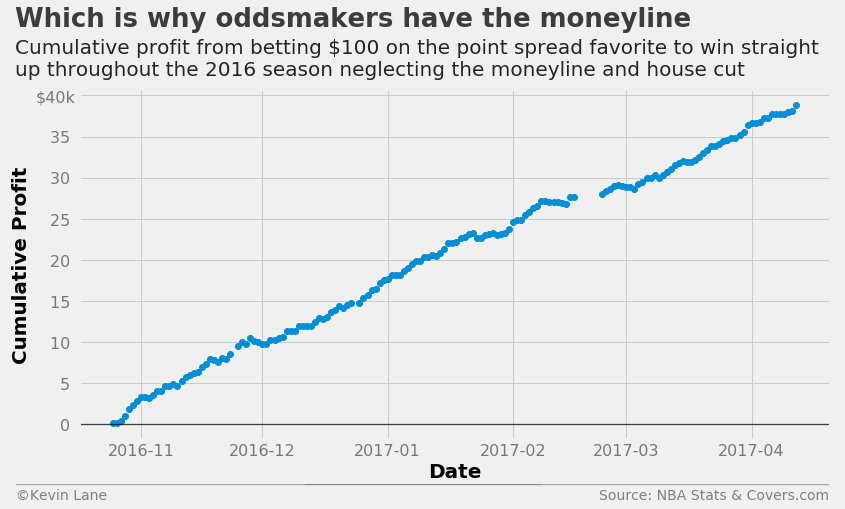

In [8]:
fig = plt.figure(figsize=(12, 6))
plt.plot_date(days, cumprofit/1000)
title = 'Which is why oddsmakers have the moneyline'
subtitle = '''Cumulative profit from betting $100 on the point spread favorite to win straight
up throughout the 2016 season neglecting the moneyline and house cut'''
format_538(fig, 'NBA Stats & Covers.com', xlabel='Date', ylabel='Cumulative Profit', title=title,
           subtitle=subtitle, xoff=(-0.095, 1.01), yoff=(-0.12, -0.17), toff=(-0.085, 1.18),
           soff=(-0.085, 1.04), prefix='$', suffix='k', suffix_offset=1)
plt.show()

Following the same procedure for predicting winners against the spread is not as successful. The accuracy settles out to a hair below 50% and we end up losing a little bit of money. This accuracy makes sense since we saw during [data exploration](data-exploration.md) that home teams win about 50% of the time against the spread.

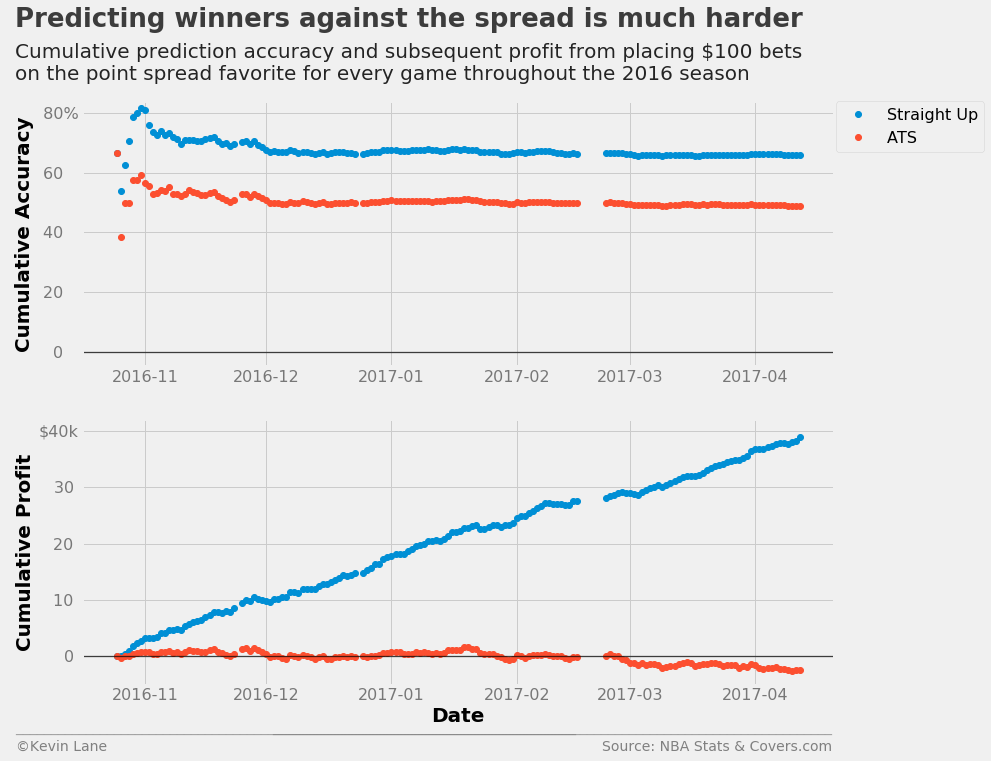

In [9]:
fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot(211)
ax1.plot_date(days, cumper*100, label='Straight Up')
ax1.plot_date(days_spread, cumper_spread*100, label='ATS')
ax1.set_ylabel('Cumulative Accuracy')
ax1.set_ylim(-5)
ax1.legend(fontsize=16, bbox_to_anchor=(1.2, 1), borderaxespad=0)

ax2 = plt.subplot(212)
ax2.plot_date(days, cumprofit/1000, label='Straight Up')
ax2.plot_date(days_spread, cumprofit_spread/1000, label='ATS')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Profit')
ax2.set_ylim(-5, 42)

title = 'Predicting winners against the spread is much harder'
subtitle = '''Cumulative prediction accuracy and subsequent profit from placing $100 bets
on the point spread favorite for every game throughout the 2016 season'''
format_538(fig, 'NBA Stats & Covers.com', ax=(ax1, ax2), title=title, subtitle=subtitle,
           xoff=(-0.1, 1.01), yoff=(-1.38, -1.45), toff=(-.09, 1.28), soff=(-0.09, 1.08), 
           prefix = (' ', '$'), suffix=('%', 'k'), suffix_offset=(3, 1), n=80)
plt.show()

# Offensive/Defensive Ratings

As a first attempt at predicting game winners against the spread using machine learning, I used logistic regression trained with home point spread and offensive and defensive ratings. Logistic regression (using scikit-learn's [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) class) is well-suited to this type of binary classification problem and when trained with team point ratings was the best-performing model in the initial project for predicting home winners straight up, so it was a reasonable place to start. The simulate method makes predictions on each day of the season and allows retraining with games already predicted. Retraining is explored in [model performance](model-performance.md). The predicted variable encodes the W/L values to 1 and 0 using scikit-learn's [`LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder) class.

In [10]:
ratings = ['TEAM_OFF_RTG', 'TEAM_DEF_RTG', 'TEAM_OFF_RTG_AWAY', 'TEAM_DEF_RTG_AWAY', 'HOME_SPREAD']
games_sub = games[ratings + ['SEASON', 'GAME_DATE', var_predict]].dropna()
output = simulate(LogisticRegression(), games_sub, 2016, ratings, var_predict)
days_rtg, cumper_rtg, cumprofit_rtg = profit(output, var_predict=var_predict, bet_amount=100)

This method starts out worse than just betting on the favorite, but eventually overtakes it about a month into the season and ends up making about \$3,000. While the model results in a profit, the return on investment is very low. This assumes bettors make \$100 bets on every game, which results in a total of \$123,000 wagered at the end of a full-length season (82 games in a 30-team league).

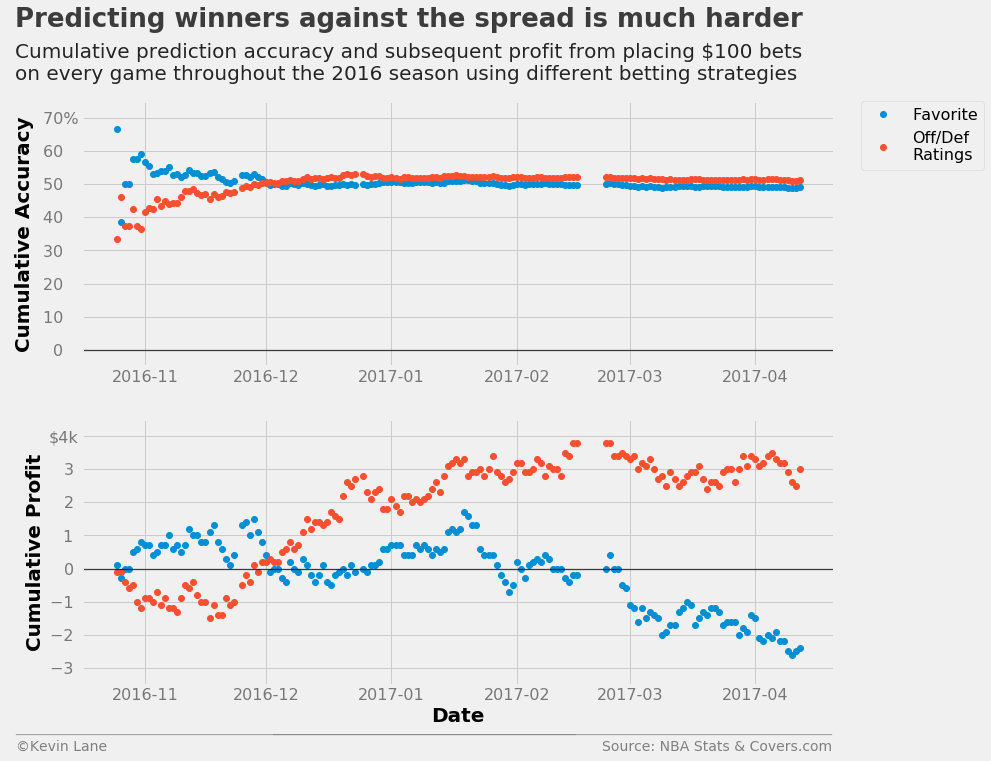

In [11]:
fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot(211)
ax1.plot_date(days_spread, cumper_spread*100, label='Favorite')
ax1.plot_date(days_rtg, cumper_rtg*100, label='Off/Def\nRatings')
ax1.set_ylabel('Cumulative Accuracy')
ax1.set_ylim(-5, 75)
ax1.legend(fontsize=16, bbox_to_anchor=(1.2, 1), borderaxespad=0)

ax2 = plt.subplot(212)
ax2.plot_date(days_spread, cumprofit_spread/1000)
ax2.plot_date(days_rtg, cumprofit_rtg/1000)
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Profit')
ax2.set_ylim(-3.5, 4.5)

title = 'Predicting winners against the spread is much harder'
subtitle = '''Cumulative prediction accuracy and subsequent profit from placing $100 bets
on every game throughout the 2016 season using different betting strategies'''
format_538(fig, 'NBA Stats & Covers.com', ax=(ax1, ax2), title=title, subtitle=subtitle,
           xoff=(-0.1, 1.01), yoff=(-1.38, -1.45), toff=(-.09, 1.28), soff=(-0.09, 1.08), 
           prefix = (' ', '$'), suffix=('%', 'k'), suffix_offset=(3, 1), n=80)
plt.show()

Next I wanted to look at some cross-validation. The function below grabs all seasons between 2006-2016 and reserves the 2016 season as the test set.

In [12]:
x_train, y_train, x_test, y_test = train_test_split(games, 2006, 2016, ylabel=var_predict,
                                                    xlabels=stat_names() + ['SEASON', 'HOME_WL'])
x_train = x_train.drop('SEASON', axis=1)

The code below plots cross-validated ROC and precision/recall curves. It also plots the curves for each fold of the cross validation. It first performs a k-fold cross-validation to get the predicted probabilities of each instance using [`cross_val_predict`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict) and [`StratifiedKFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold). The predicted probabilities of the positive class (home team wins) are input into [`roc_curve`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve) and [`roc_auc_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) to get the mean ROC curve and area under the curve. The process is similar for the cross-validated precision/recall curve using [`precision_recall_curve`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve) and [`average_precision_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score). The areas under the curves are displayed on the legend when the legend is shown.

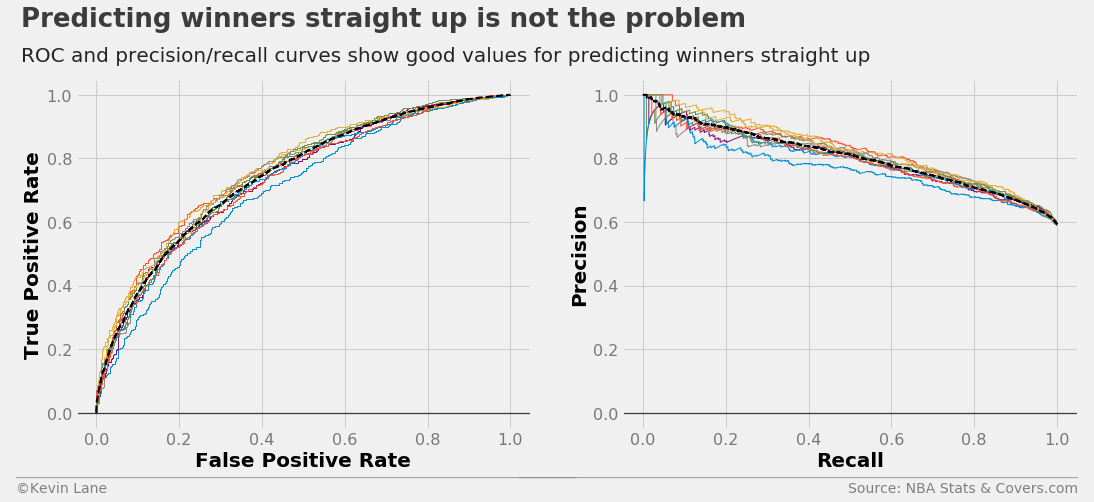

In [13]:
season = 2016
y = LabelEncoder().fit_transform(x_train.HOME_WL)
model = LogisticRegression()
fig, ax1, ax2 = cross_val_curves(model, x_train[ratings], y, legend=False)
title = 'Predicting winners straight up is not the problem'
subtitle = 'ROC and precision/recall curves show good values for predicting winners straight up'
format_538(fig, 'NBA Stats & Covers.com', ax=(ax1, ax2), title=title, subtitle=subtitle,
           xoff=(-0.15, 2.22), yoff=(-0.13, -0.18), toff=(-.12, 1.15), soff=(-0.12, 1.05), n=80)
plt.show()

An ROC curve compares a classifier's true positive rate ($$TPR$$) to its false positive rate ($$FPR$$), where:

$$\begin{align}
TPR & =\frac{TP}{TP+FN} \\
FPR & =\frac{FP}{FP+TN} \\
TP & =\text{true positive} \\
FP & =\text{false positive} \\
TN & =\text{true negative} \\
FN & =\text{false negative}
\end{align}$$

Therefore, a perfect classifier ($$TPR=1$$ and $$FPR=0$$) would be located in the upper left corner of an ROC curve. The aptly-named precision/recall curve compares a classifier's precision with its recall, which are defined as:

$$\begin{align}
\text{Precision} & =\frac{TP}{TP+FP} \\
\text{Recall} & =TPR
\end{align}$$

making the ideal point of a precision/recall curve the upper right corner. The ROC and precision/recall curves below are for winners against the spread. The nearly y=x relationship of the ROC curve and flat precision/recall curve indicate the model is no better than random guessing, which makes sense given it is about 50% accurate.

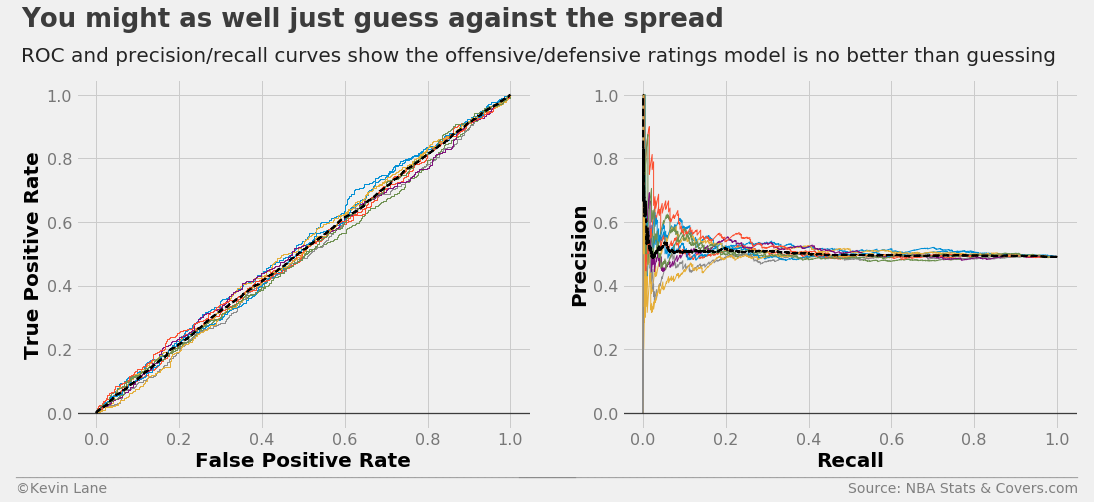

In [14]:
model = LogisticRegression()
fig, ax1, ax2 = cross_val_curves(model, x_train[ratings], y_train, legend=False)
title = 'You might as well just guess against the spread'
subtitle = 'ROC and precision/recall curves show the offensive/defensive ratings model is no better than guessing'
format_538(fig, 'NBA Stats & Covers.com', ax=(ax1, ax2), title=title, subtitle=subtitle,
           xoff=(-0.15, 2.22), yoff=(-0.13, -0.18), toff=(-.12, 1.15), soff=(-0.12, 1.05), n=80)
plt.show()

# Select Features Automatically

Next I wanted to investigate how well automatically-selected stats perform. The code below uses [`SelectKBest`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) to select the 20 best attributes according to the [ANOVA F-value](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif). This uses a process called [univariate feature selection](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py), which uses univariate statistical tests to select features. In the first project, the majority of automatically-selected attributes were point ratings (SRS, offensive rating, etc.). However none of the point rating stats appear until well down the list. The FOUR_FACTORS stat is the weighted sum of the four factors. The FOUR_FACTORS_REB stat is identical with the exception that it includes defensive rebounds. The two definitions of the four factors are weighted according to Oliver's selected weights (discussed during [stat collection](stats.md)) and combined into single metrics as:

$$FF=0.4*EFG\% + 0.2*OREB\% + 0.15*FTR - 0.25*TOV\%$$
$$FF_{REB}=0.4*EFG\% + 0.1*OREB\% + 0.1*DREB\% + 0.15*FTR - 0.25*TOV\%$$

In [15]:
if 'HOME_WL' in x_train.columns:
    x_train = x_train.drop('HOME_WL', axis=1)

kbest_anova = SelectKBest(f_classif, k=20).fit(x_train, y_train)

for label in x_train.columns[kbest_anova.get_support()]:
    print(label)

TEAM_FG3M
TEAM_FG3A
TEAM_STL
OPP_FG3M
OPP_OREB
OPP_AST
TEAM_FGM_AWAY
TEAM_FGA_AWAY
TEAM_DREB_AWAY
TEAM_REB_AWAY
OPP_FGA_AWAY
OPP_FG3A_AWAY
TEAM_OFF_RTG
TEAM_FOUR_FACTORS
TEAM_FOUR_FACTORS_REB
TEAM_OFF_RTG_AWAY
TEAM_NET_RTG_AWAY
TEAM_FOUR_FACTORS_AWAY
TEAM_FOUR_FACTORS_REB_AWAY
POSSESSIONS_AWAY


Selecting the 20 best features using a [chi-square test](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2) selects similar attributes as the ANOVA F-value above. The chi-square test only works on positive values, so each feature in the training data is scaled to fall between 0 and 1 using the [`MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) class.

In [16]:
kbest_chi2 = SelectKBest(chi2, k=20).fit(MinMaxScaler((0, 1)).fit_transform(x_train), y_train)

for label in x_train.columns[kbest_chi2.get_support()]:
    print(label)

TEAM_FG3M
TEAM_FG3A
TEAM_STL
OPP_FG3M
OPP_AST
TEAM_FGM_AWAY
TEAM_FGA_AWAY
TEAM_FG3A_AWAY
TEAM_FTA_AWAY
TEAM_DREB_AWAY
TEAM_REB_AWAY
OPP_FGA_AWAY
OPP_FG3A_AWAY
OPP_AST_AWAY
TEAM_FOUR_FACTORS_REB
TEAM_OFF_RTG_AWAY
TEAM_NET_RTG_AWAY
TEAM_FOUR_FACTORS_AWAY
TEAM_FOUR_FACTORS_REB_AWAY
POSSESSIONS_AWAY


The ROC and precision/recall curves below use the 20 best stats selected by the ANOVA F-value. They appear very similar to those about using offensive/defensive ratings.

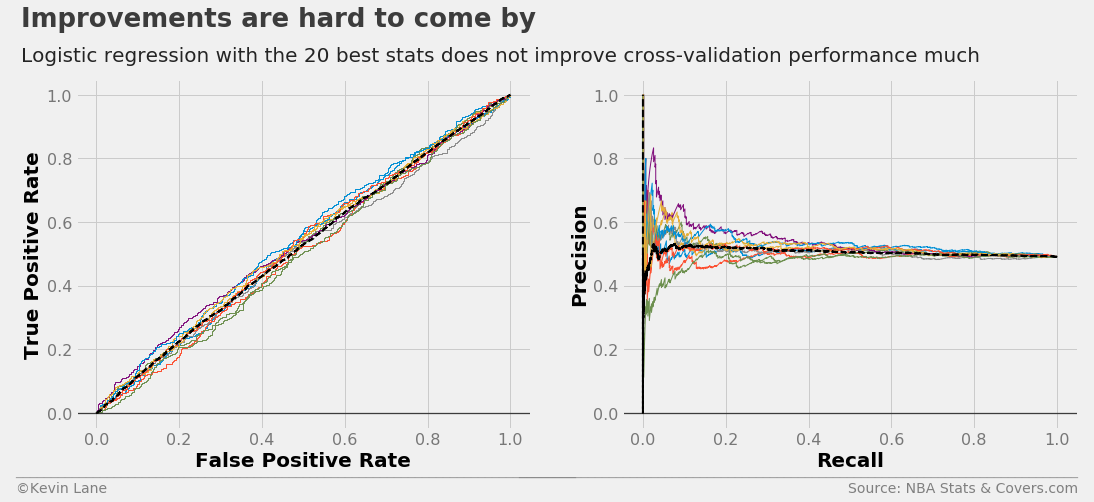

In [17]:
kbest_stats = x_train.columns[kbest_anova.get_support()].tolist()
model = LogisticRegression()
fig, ax1, ax2 = cross_val_curves(model, x_train[kbest_stats], y_train, legend=False)
title = 'Improvements are hard to come by'
subtitle = 'Logistic regression with the 20 best stats does not improve cross-validation performance much'
format_538(fig, 'NBA Stats & Covers.com', ax=(ax1, ax2), title=title, subtitle=subtitle,
           xoff=(-0.15, 2.22), yoff=(-0.13, -0.18), toff=(-.12, 1.15), soff=(-0.12, 1.05), n=80)
plt.show()

The code below calculates profit for the 2016 season using the 20 best stats for a comparison at the end.

In [18]:
games_sub = games[kbest_stats + ['SEASON', 'GAME_DATE', var_predict]].dropna()
output = simulate(LogisticRegression(), games_sub, 2016, kbest_stats, var_predict)
days_kbest, cumper_kbest, cumprofit_kbest = profit(output, var_predict=var_predict, bet_amount=100)

# Compare Attribute Groupings

I then wanted to test a simpler method using only basic box score stats (FG, REB, AST, etc.) for the average user. The ROC and precision/recall curves below do not show much improvement.

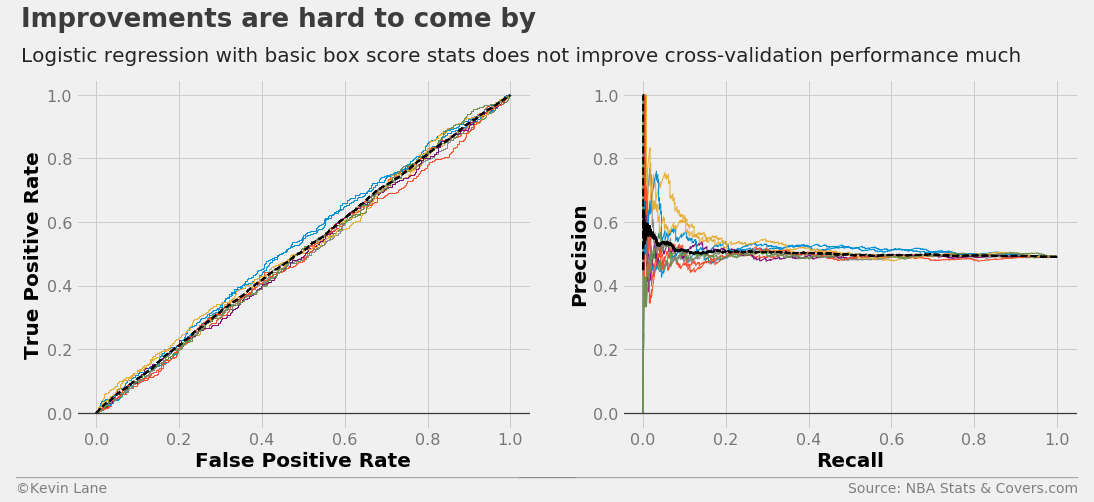

In [19]:
stats = ['FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK']
stats = ['TEAM_' + s for s in stats] + ['POSSESSIONS']
stats += [s + '_AWAY' for s in stats] + ['HOME_SPREAD']
model = LogisticRegression()
fig, ax1, ax2 = cross_val_curves(model, x_train[stats], y_train, legend=False)
title = 'Improvements are hard to come by'
subtitle = 'Logistic regression with basic box score stats does not improve cross-validation performance much'
format_538(fig, 'NBA Stats & Covers.com', ax=(ax1, ax2), title=title, subtitle=subtitle,
           xoff=(-0.15, 2.22), yoff=(-0.13, -0.18), toff=(-.12, 1.15), soff=(-0.12, 1.05), n=80)
plt.show()

The code below calculates profit for the 2016 season using basic box score stats for a comparison at the end.

In [20]:
games_sub = games[stats + ['SEASON', 'GAME_DATE', var_predict]].dropna()
output = simulate(LogisticRegression(), games_sub, 2016, stats, var_predict)
days_box, cumper_box, cumprofit_box = profit(output, var_predict=var_predict, bet_amount=100)

The code below plots 10-fold cross-validated ROC and precision/recall curves using logistic regression models trained with different attribute groupings. I added a [`FunctionTransformer`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html#sklearn.preprocessing.FunctionTransformer) that selects columns from the `DataFrame` to simplify the process of specifying all the attributes. The selector and classifier are combined into a scikit-learn [`Pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#) using the [`make_pipeline`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html#sklearn.pipeline.make_pipeline) function.

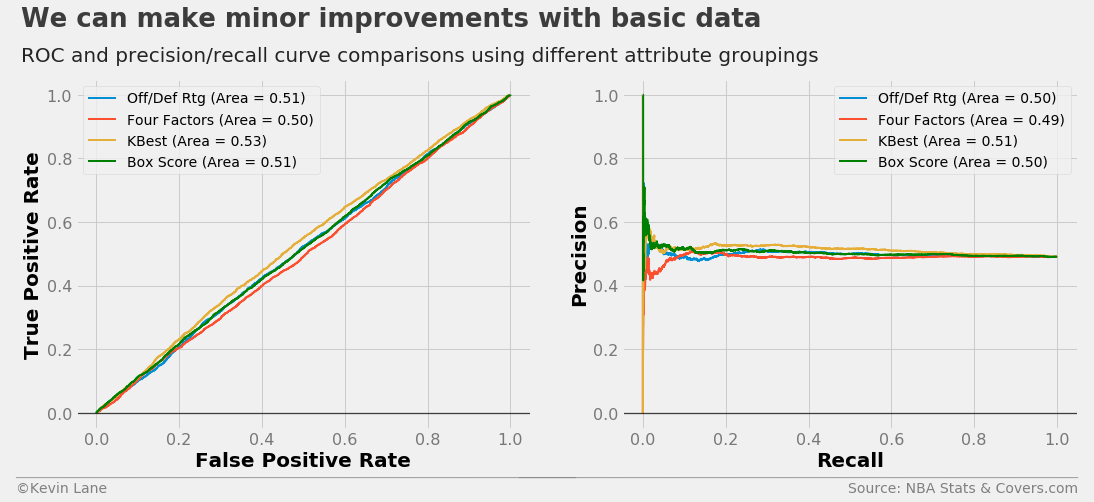

In [21]:
# Define attributes to use for each curve
four_factors = ['EFG', 'TOV_PCT', 'OREB_PCT', 'DREB_PCT', 'FT_PER_FGA']
attributes = [['OFF_RTG', 'DEF_RTG'], four_factors, kbest_stats, stats]
labels = ['Off/Def Rtg', 'Four Factors', 'KBest', 'Box Score']

fig = plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121)

# Plot ROC curves for each set of attributes
for (a, l) in zip(attributes, labels):
    # Make transformer that selects the desired attributes from the DataFrame
    selector = FunctionTransformer(partial(select_columns, attributes=a, columns=x_train.columns))
    
    # Make a pipeline that selects the desired attributes prior to the classifier
    model = make_pipeline(selector, LogisticRegression())
    cross_val_roc_curve(model, x_train, y_train, ax1, label=l, show_folds=False)

ax1.get_lines()[-1].set_color('green')
ax1.legend(fontsize=14)
ax2 = plt.subplot(122)

# Plot ROC curves for each set of attributes
for (a, l) in zip(attributes, labels):
    # Make transformer that selects the desired attributes from the DataFrame
    selector = FunctionTransformer(partial(select_columns, attributes=a, columns=x_train.columns))
    
    # Make a pipeline that selects the desired attributes prior to the classifier
    model = make_pipeline(selector, LogisticRegression())
    cross_val_precision_recall_curve(model, x_train, y_train, ax2, label=l, show_folds=False)

ax2.get_lines()[-1].set_color('green')
ax2.legend(fontsize=14)

title = 'We can make minor improvements with basic data'
subtitle = 'ROC and precision/recall curve comparisons using different attribute groupings'
format_538(fig, 'NBA Stats & Covers.com', ax=(ax1, ax2), title=title, subtitle=subtitle,
           xoff=(-0.15, 2.22), yoff=(-0.13, -0.18), toff=(-.12, 1.15), soff=(-0.12, 1.05), n=80)
plt.show()

The plots below show accuracy and profits throughout the 2016 season using logistic regression models trained with different sets of stats compared with simply picking the favorite. All the logistic regression models end up making money, but the model trained with the complete set of box score stats outperforms all others.

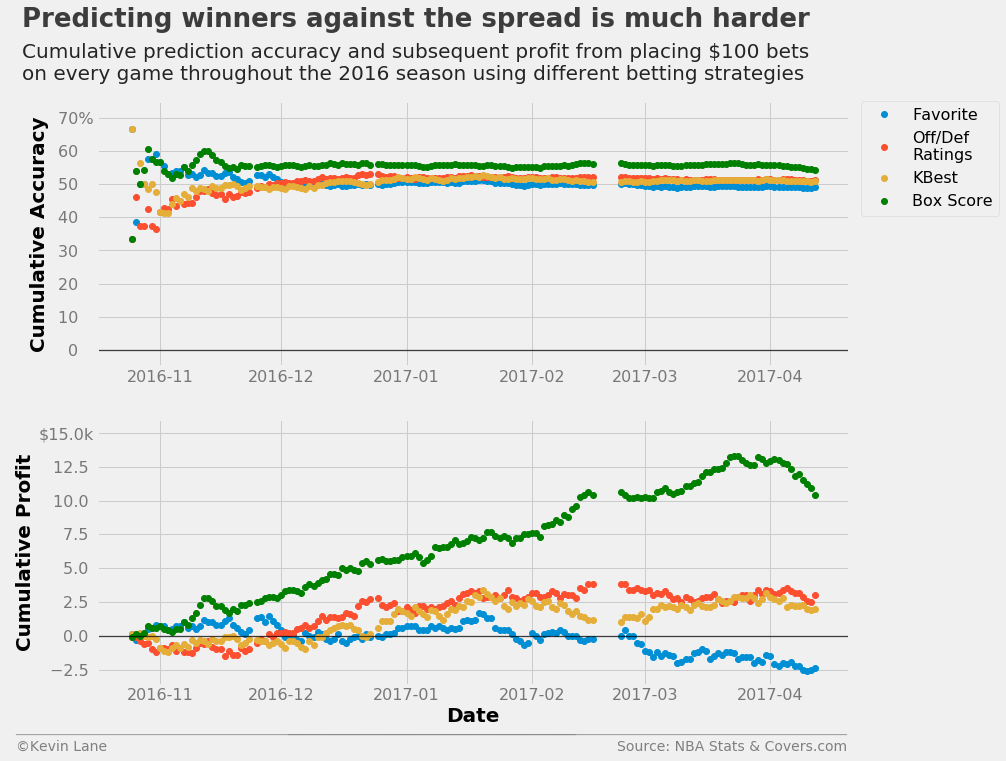

In [22]:
fig = plt.figure(figsize=(12, 10))
ax1 = plt.subplot(211)
ax1.plot_date(days_spread, cumper_spread*100, label='Favorite')
ax1.plot_date(days_rtg, cumper_rtg*100, label='Off/Def\nRatings')
ax1.plot_date(days_kbest, cumper_kbest*100, label='KBest')
ax1.plot_date(days_box, cumper_box*100, label='Box Score', color='green')
ax1.set_ylabel('Cumulative Accuracy')
ax1.set_ylim(-5, 75)
ax1.legend(fontsize=16, bbox_to_anchor=(1.2, 1), borderaxespad=0)

ax2 = plt.subplot(212)
ax2.plot_date(days_spread, cumprofit_spread/1000)
ax2.plot_date(days_rtg, cumprofit_rtg/1000)
ax2.plot_date(days_kbest, cumprofit_kbest/1000)
ax2.plot_date(days_box, cumprofit_box/1000, color='green')
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Profit')
ax2.set_ylim(-3.6, 16)

title = 'Predicting winners against the spread is much harder'
subtitle = '''Cumulative prediction accuracy and subsequent profit from placing $100 bets
on every game throughout the 2016 season using different betting strategies'''
format_538(fig, 'NBA Stats & Covers.com', ax=(ax1, ax2), title=title, subtitle=subtitle,
           xoff=(-0.12, 1.01), yoff=(-1.38, -1.45), toff=(-.1, 1.28), soff=(-0.1, 1.08), 
           prefix = (' ', '$'), suffix=('%', 'k'), suffix_offset=(3, 1), n=80)
plt.show()